In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import shap
import dill
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from reindexing import index_groupid
from custom_metrics import recall_at_k, map_at_k
import pandas as pd; pd.set_option('max_columns', None)
from catboost import CatBoostClassifier, CatBoost, Pool

%matplotlib inline 
shap.initjs()

### Чтение и предобработка данных

In [4]:
train = pd.read_csv('../data/train_with_all_features.csv')

train['clientid'] = train['clientid'].astype('uint32')
train['itemid'] = train['itemid'].astype('uint32')
train['jointitemid'] = train['jointitemid'].astype('uint32')
train['count_on_session_view'] = train['count_on_session_view'].astype('uint32')
train['count_on_session_tocart'] = train['count_on_session_tocart'].astype('uint32')
train['label'] = train['label'].astype('int8')
train['novelty_cnt'] = train['novelty_cnt'].astype('uint32')
train = train.drop('timestamp', axis=1)

train.shape

(1390438, 28)

In [5]:
test = pd.read_csv('../data/test_with_all_features.csv')

test['clientid'] = test['clientid'].astype('uint32')
test['itemid'] = test['itemid'].astype('uint32')
test['jointitemid'] = test['jointitemid'].astype('uint32')
test['count_on_session_view'] = test['count_on_session_view'].astype('uint32')
test['count_on_session_tocart'] = test['count_on_session_tocart'].astype('uint32')
test['label'] = test['label'].astype('int8')
test['novelty_cnt'] = test['novelty_cnt'].astype('uint32')
test = test.drop('timestamp', axis=1)

test.shape

(597158, 28)

### Модель

In [6]:
X_train = train.drop(['label', 'clientid', 'itemid', 'jointitemid'], axis=1)
X_test = test.drop(['label', 'clientid', 'itemid', 'jointitemid'], axis=1)
y_train = train['label']
y_test = test['label']

In [7]:
params = {
    'iterations': 1500,
    'depth': 5,
    'l2_leaf_reg': 5, # 3-10
    'learning_rate': 0.1,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'early_stopping_rounds': 100,
    'use_best_model': True, 
    'random_seed': 42
}

model = CatBoostClassifier(**params)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)

0:	test: 0.6057334	best: 0.6057334 (0)	total: 784ms	remaining: 19m 35s
100:	test: 0.6316959	best: 0.6316959 (100)	total: 1m 5s	remaining: 15m 8s
200:	test: 0.6337102	best: 0.6337102 (200)	total: 2m 10s	remaining: 14m 5s
300:	test: 0.6345870	best: 0.6345931 (298)	total: 3m 18s	remaining: 13m 12s
400:	test: 0.6352526	best: 0.6352526 (400)	total: 4m 24s	remaining: 12m 4s
500:	test: 0.6354276	best: 0.6354352 (470)	total: 5m 32s	remaining: 11m 2s
600:	test: 0.6355918	best: 0.6355918 (600)	total: 6m 38s	remaining: 9m 56s
700:	test: 0.6357386	best: 0.6357436 (698)	total: 7m 47s	remaining: 8m 53s
800:	test: 0.6358766	best: 0.6358863 (791)	total: 8m 53s	remaining: 7m 45s
900:	test: 0.6359357	best: 0.6359357 (900)	total: 10m 4s	remaining: 6m 41s
1000:	test: 0.6359282	best: 0.6359524 (952)	total: 11m 5s	remaining: 5m 31s
1100:	test: 0.6360357	best: 0.6360407 (1097)	total: 12m 7s	remaining: 4m 23s
1200:	test: 0.6360588	best: 0.6360594 (1198)	total: 13m 8s	remaining: 3m 16s
1300:	test: 0.6360733	be

In [8]:
with open('../models/cat_model.dill', 'wb') as f:
    dill.dump(model, f)

In [9]:
test.loc[:, 'predict_proba'] = model.predict_proba(X_test)[:, 1]

In [10]:
print(f'map@3: {map_at_k(test, 3):.3}')
print(f'recall@3: {recall_at_k(test, 3):.3}')

map@3: 0.137
recall@3: 0.538


### Важность признаков

In [11]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train)

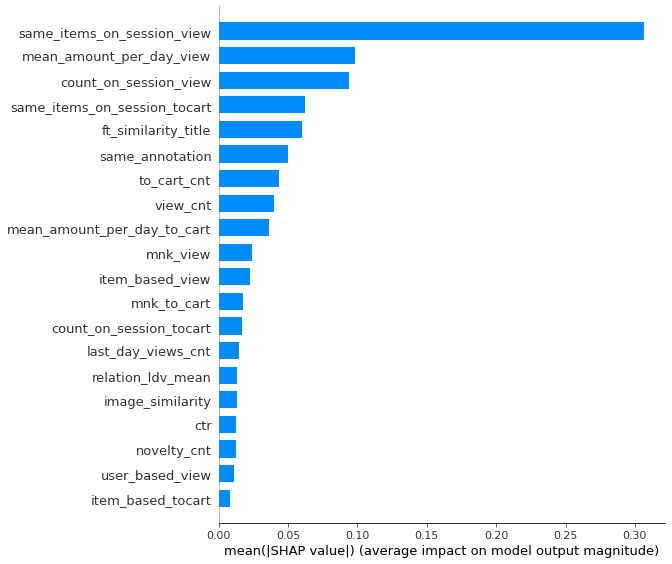

In [12]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

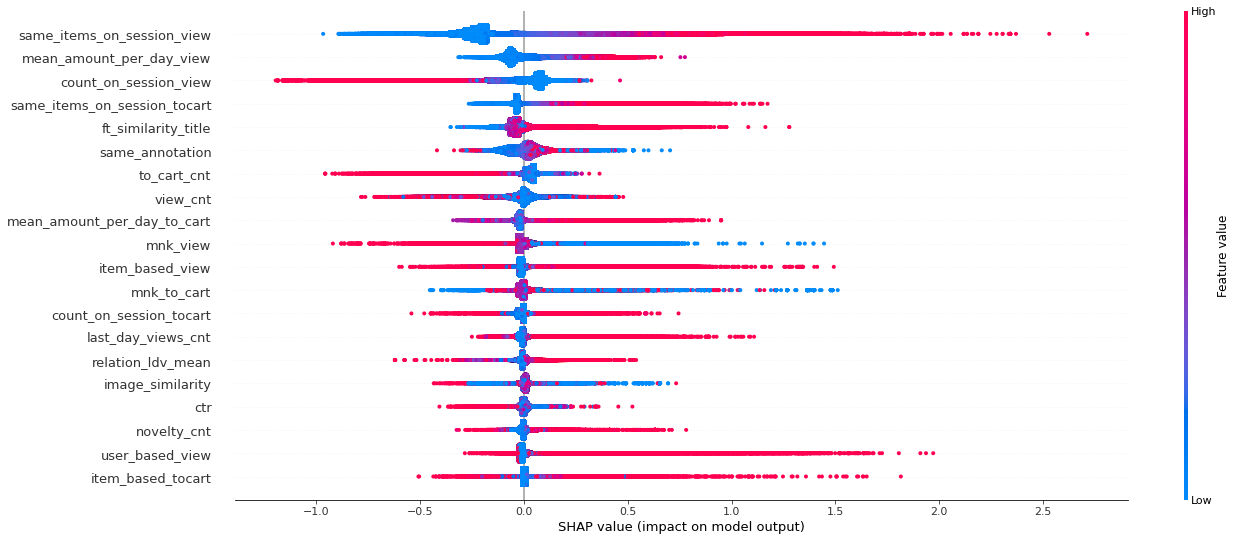

In [13]:
shap.summary_plot(shap_values, X_train, plot_size=(20, 9))

### Ранжирование

In [14]:
train = train.assign(clientid_itemid=[*zip(train['clientid'],
                                           train['itemid'])])

train = index_groupid(train)

In [15]:
test = test.assign(clientid_itemid=[*zip(test['clientid'],
                                         test['itemid'])])

test = index_groupid(test)

Для ранжирования необходимо, чтобы столбец <strong>group_id</strong> был отсортирован

In [16]:
train = train.sort_values('group_id')
test = test.sort_values('group_id')

In [17]:
train.head(2)

,clientid,itemid,jointitemid,label,view_cnt,to_cart_cnt,ctr,novelty_cnt,mean_amount_per_day_view,mean_amount_per_day_to_cart,last_day_views_cnt,last_day_to_cart_cnt,relation_ldv_mean,relation_ldtocart_mean,mnk_view,mnk_to_cart,same_items_on_session_view,count_on_session_view,same_items_on_session_tocart,count_on_session_tocart,item_based_view,item_based_tocart,user_based_view,user_based_tocart,same_title,same_annotation,ft_similarity_title,image_similarity,clientid_itemid,group_id
0,7833842,31499843,138176581,1,31.0,9.0,0.281250,737272,1.722222,1.500,0.0,0.0,0.000000,0.0,0.107143,0.035714,0.0,0,0.069338,1,0.0,0.0,0.0,0.0,0.0,0.101405,0.163774,0.653006,"(7833842, 31499843)",0
442231,7833842,31499843,140178702,0,36.0,9.0,0.243243,737272,1.636364,1.125,2.0,0.0,1.222222,0.0,0.214286,0.071429,0.0,0,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.172817,0.303897,0.611332,"(7833842, 31499843)",0


In [18]:
X_train_rank = train.drop(['label', 'clientid', 'itemid', 
                           'jointitemid', 'clientid_itemid'], axis=1)
X_test_rank = test.drop(['label', 'clientid', 'itemid', 'jointitemid',
                         'predict_proba', 'clientid_itemid'], axis=1)
y_train_rank = train['label']
y_test_rank = test['label']

In [19]:
train_pool = Pool(
    data=X_train_rank,
    label=y_train_rank,
    group_id=X_train_rank['group_id']
)

test_pool = Pool(
    data=X_test_rank,
    label=y_test_rank,
    group_id=X_test_rank['group_id']
)

### Подбор метрики ранжирования
     – YetiRank
     – YetiRankPairwise
     – PairLogit
     – PairLogitPairwise

In [20]:
params_rank = {
    'iterations': 1500,
    'depth': 5,
    'l2_leaf_reg': 5, # 3-10
    'learning_rate': 0.1,
    'loss_function': 'YetiRankPairwise',
    'train_dir': 'YetiRankPairwise',
    'custom_metric': ['MAP:top=3', 'RecallAt:top=3', 'AUC'],
    'early_stopping_rounds': 100,
    'use_best_model': True, 
    'random_seed': 42
}

model = CatBoost(params_rank)
model.fit(train_pool, eval_set=test_pool, plot=True, verbose=100)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5883159	best: 0.5883159 (0)	total: 2.88s	remaining: 1h 11m 51s
100:	test: 0.6969021	best: 0.6969021 (100)	total: 5m 36s	remaining: 1h 17m 44s
200:	test: 0.6991881	best: 0.6991881 (200)	total: 11m 16s	remaining: 1h 12m 49s
300:	test: 0.7004350	best: 0.7004438 (298)	total: 17m 43s	remaining: 1h 10m 37s
400:	test: 0.7008398	best: 0.7008398 (400)	total: 25m 14s	remaining: 1h 9m 10s
500:	test: 0.7011648	best: 0.7012141 (483)	total: 32m 43s	remaining: 1h 5m 15s
600:	test: 0.7013624	best: 0.7014415 (590)	total: 40m 21s	remaining: 1h 22s
700:	test: 0.7016109	best: 0.7016589 (686)	total: 47m 46s	remaining: 54m 27s
800:	test: 0.7018177	best: 0.7018177 (800)	total: 55m 16s	remaining: 48m 13s
900:	test: 0.7017578	best: 0.7018549 (805)	total: 1h 2m 40s	remaining: 41m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7018549169
bestIteration = 805

Shrink model to first 806 iterations.


In [21]:
test.loc[:, 'predict_proba'] = model.predict(test_pool)

In [22]:
print(f'map@3: {map_at_k(test, 3):.3}')
print(f'recall@3: {recall_at_k(test, 3):.3}')

map@3: 0.138
recall@3: 0.543


In [23]:
maps = []
recalls = []

for k in tqdm(range(1, 11)):
    maps.append(map_at_k(test, k))
    recalls.append(recall_at_k(test, k))

  0%|          | 0/10 [00:00<?, ?it/s]

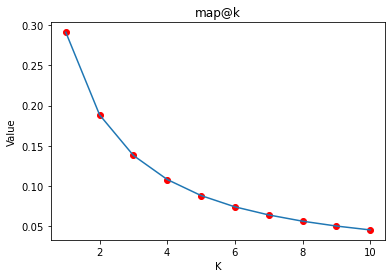

In [24]:
plt.plot(np.arange(1, 11), maps);
plt.scatter(x=np.arange(1, 11), y=maps, c='red');
plt.xlabel('K');
plt.ylabel('Value');
plt.title('map@k');

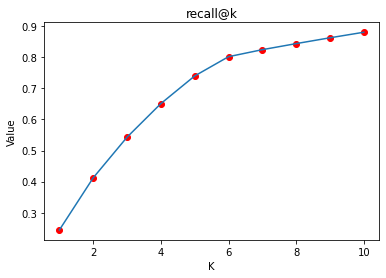

In [25]:
plt.plot(np.arange(1, 11), recalls);
plt.scatter(x=np.arange(1, 11), y=recalls, c='red');
plt.xlabel('K');
plt.ylabel('Value');
plt.title('recall@k');

In [26]:
with open('../models/cat_rank_model.dill', 'wb') as f:
    dill.dump(model, f)

### Важность признаков после ранжирования

In [27]:
with open('../models/cat_rank_model.dill', 'rb') as f:
    cat_rank_model = dill.load(f)

In [28]:
explainer = shap.TreeExplainer(cat_rank_model)

shap_values = explainer.shap_values(train_pool)

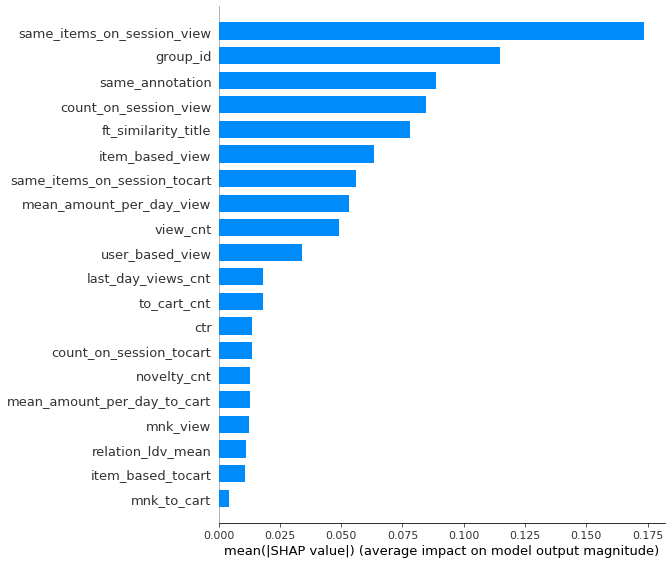

In [29]:
shap.summary_plot(
    shap_values,
    X_train_rank,
    plot_type='bar',
    feature_names=X_train_rank.columns.tolist()
)

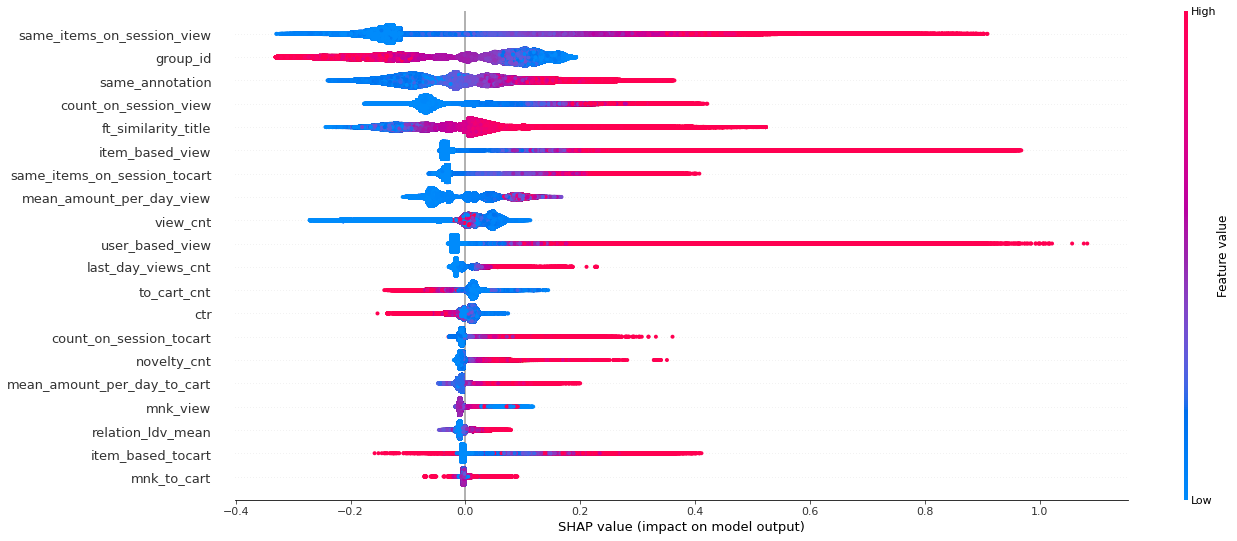

In [30]:
shap.summary_plot(
    shap_values, 
    X_train_rank,
    plot_size=(20, 9),
    feature_names=X_train_rank.columns.tolist()
)